In [193]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
from collections import Counter

print(os.getcwd())
# os.chdir('../')
# print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Step 1: Structural Comparison

In [77]:
def structural_comparison(df):
    """
    Aggregates conversation-level metrics and plots structural differences across negotiation categories.
    """
    category_colors = {
        "Shallow Exploration": "#1F77B4",
        "Functional Tension": "#FF7F0E",
        "Apathetic": "#7F7F7F",
        "Dysfunctional Tension": "#D62728"
    }

    # Aggregate to conversation level
    convo_df = df.groupby("PairID").agg({
        "Negotiation_Category": "first",
        "Turn": "max",
        "Contested": lambda x: (x > 0).sum(),
        "Sentiment": "mean",
        "word_count": "mean"
    }).rename(columns={
        "Turn": "Avg_No._of_turns",
        "Contested": "Avg_prop_contested_turns",
        "Sentiment": "Avg_Sentiment",
        "word_count": "Avg_word_count_per_turn"
    }).reset_index()

    # Melt for plotting
    melted = convo_df.melt(id_vars="Negotiation_Category", 
                            value_vars=["Avg_No._of_turns", "Avg_prop_contested_turns", "Avg_Sentiment", "Avg_word_count_per_turn"],
                            var_name="Metric", value_name="Value")

    # Compute means and standard error
    summary = melted.groupby(["Negotiation_Category", "Metric"]).agg(
        Mean_Value=("Value", "mean"),
        Std_Error=("Value", lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Create point plots with improved aesthetics
    sns.set(style="white", font_scale=1.8)
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.direction'] = 'out'
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, gridspec_kw={'hspace': 0.6})
    
    metrics = summary["Metric"].unique()
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_data = summary[summary["Metric"] == metric]
        sorted_categories = metric_data["Negotiation_Category"].tolist()
        colors = [category_colors[cat] for cat in sorted_categories]

        sns.pointplot(
            y="Negotiation_Category", x="Mean_Value", data=metric_data,
            hue="Negotiation_Category", palette=category_colors, dodge=False,
            errorbar=None, markers="o", linestyles="", ax=ax, markersize=12
        )

        for _, row in metric_data.iterrows():
            y_pos = metric_data["Negotiation_Category"].tolist().index(row["Negotiation_Category"])
            ax.errorbar(
            x=row["Mean_Value"],
            y=y_pos,
                xerr=row["Std_Error"],
                fmt='none', ecolor=category_colors[row["Negotiation_Category"]], capsize=5, lw=2
            )

        ax.set_title(metric.replace("_", " "), fontsize=18, weight='semibold', pad=20)
        ax.set_xlabel("")
        if i % 2 == 0:
            ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
        else:
            ax.tick_params(axis='y', which='major', length=6)
            ax.set_yticklabels([])  # This hides labels but not the ticks

        ax.tick_params(axis='y', which='both', length=6)
        ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', which='both', length=6)

    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call this function using:
# structural_comparison(df)


/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_30749/695536264.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_30749/695536264.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_30749/695536264.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


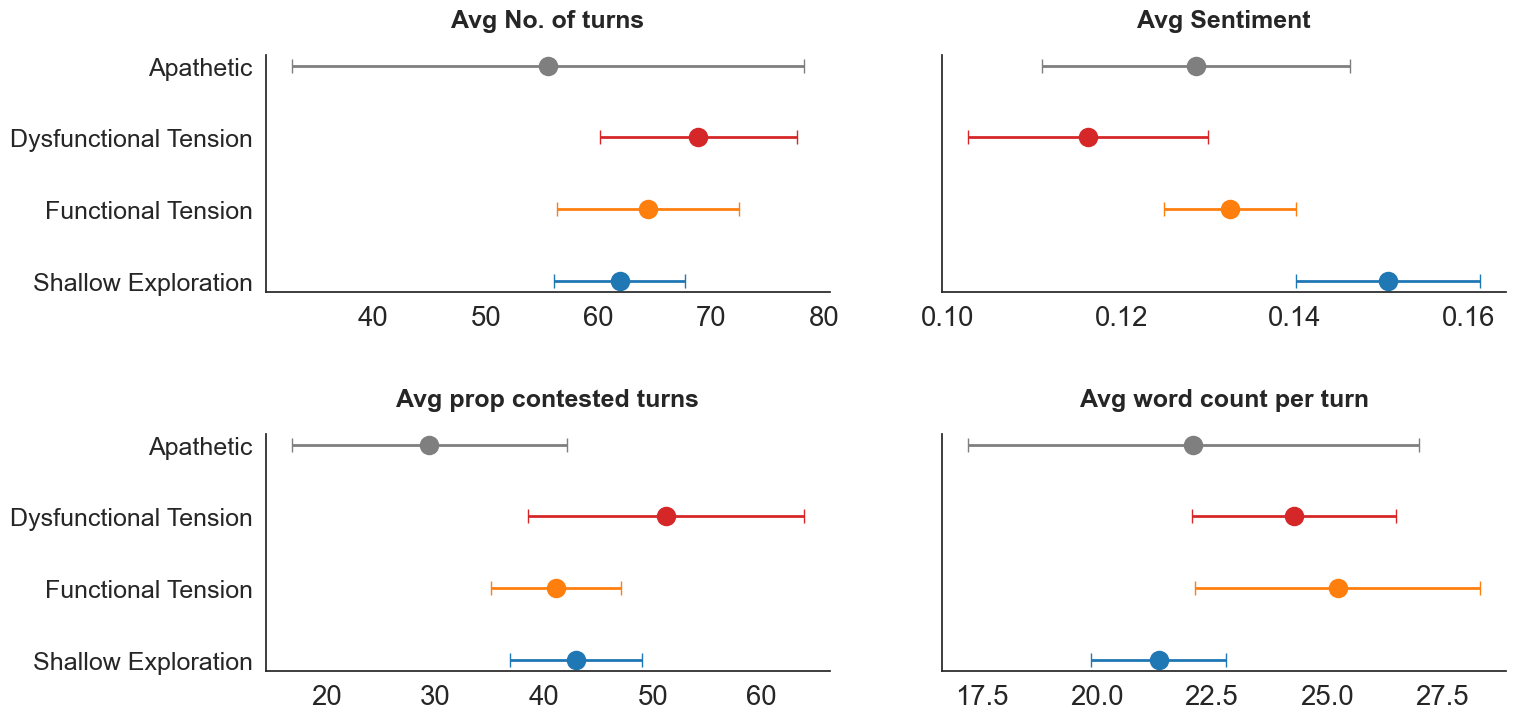

In [164]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
structural_comparison(df)

Step 2: Behavioral Patterns before and during Contested Turns


In [186]:
def analyze_pre_contested_behaviors(df, negotiation_category, n_prior_turns=2):
    """
    For a given negotiation category, compare behavioral patterns during contested turns
    and the n uncontested turns preceding each contested turn.
    """
    # Filter by category
    df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()

    # Ensure sorting for turn-based comparison
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)

    # Identify all contested turns
    contested_turns = df_cat[df_cat['Contested'] > 0][['PairID', 'Turn']]

    # Find n uncontested prior turns for each contested one
    prior_turns = []
    for _, row in contested_turns.iterrows():
        pid, turn = row['PairID'], row['Turn']
        prior_df = df_cat[(df_cat['PairID'] == pid) & (df_cat['Turn'] < turn)].tail(n_prior_turns)
        if len(prior_df) == n_prior_turns and all(prior_df['Contested'] == 0):
            prior_turns.append(prior_df)

    prior_df = pd.concat(prior_turns) if prior_turns else pd.DataFrame()
    contested_df = df_cat[df_cat.set_index(['PairID', 'Turn']).index.isin(
        contested_turns.set_index(['PairID', 'Turn']).index)]

    # Add label
    prior_df['Label'] = 'Pre-Contested'
    contested_df['Label'] = 'Contested'

    # Combine
    combined_df = pd.concat([prior_df, contested_df])

    # Format only behavioral feature column names
    behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())

    # Define behavioral features
    feature_start = df.columns.get_loc("Acknowledgement")
    feature_end = df.columns.get_loc("Smile") + 1
    behavior_cols = df.columns[feature_start:feature_end]

    # Prepare data
    X = combined_df[behavior_cols]
    y = combined_df['Label'].map({"Pre-Contested": 0, "Contested": 1})

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # SHAP summary plot
    # Identify modality for each feature
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    facial_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer", "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right", "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose Openjaw", "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker", "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]

    X_formatted = X.copy()

    # Split top and bottom features for side-by-side presentation
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    sorted_indices = np.argsort(mean_abs_shap)
    top_idx = sorted_indices[-10:]
    bottom_idx = sorted_indices[-20:-10]

    top_features = X_formatted.columns[top_idx]
    bottom_features = X_formatted.columns[bottom_idx]
    X_top = X_formatted.iloc[:, top_idx]
    X_bottom = X_formatted.iloc[:, bottom_idx]
    
    shap.summary_plot(shap_values[:, top_idx], X_top, plot_type="dot", show=False, plot_size=(8, 6))
    plt.title("Top Features (1–10)", fontsize=14)
    plt.xlabel("SHAP Values:\nPredictive Power of Contested Turn (→ Right)\nvs. Pre-Contested Turn (← Left)", fontsize=12)
    plt.tight_layout()
    plt.show()
    shap.summary_plot(shap_values[:, bottom_idx], X_bottom, plot_type="dot", show=False, plot_size=(8, 6))
    plt.title("Top Features (11–20)", fontsize=14)
    plt.xlabel("SHAP Values:\nPredictive Power of Contested Turn (→ Right)\nvs. Pre-Contested Turn (← Left)", fontsize=12)
    plt.tight_layout()
    plt.show()

    # SHAP scatter comparison
    shap_df = pd.DataFrame({
        'Feature': behavior_cols,
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    # Determine modality for coloring
    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Facial'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)

    # Label features significantly different from diagonal
    shap_df['Diff'] = shap_df['SHAP Contested'] - shap_df['SHAP Pre-Contested']
    threshold = 0.05  # customize this threshold
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Facial': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Pre-Contested', y='SHAP Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Pre-Contested)')
    plt.ylabel('SHAP Value (Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
    # Annotate significantly different points
    from adjustText import adjust_text

    texts = []
    for i, row in shap_df[shap_df['Label'] != ''].iterrows():
        x, y = row['SHAP Pre-Contested'], row['SHAP Contested']
        texts.append(plt.text(x, y, row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_pre_contested_behaviors(df, negotiation_category="Functional Tension", n_prior_turns=2)


/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_30749/2493182183.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contested_df['Label'] = 'Contested'
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


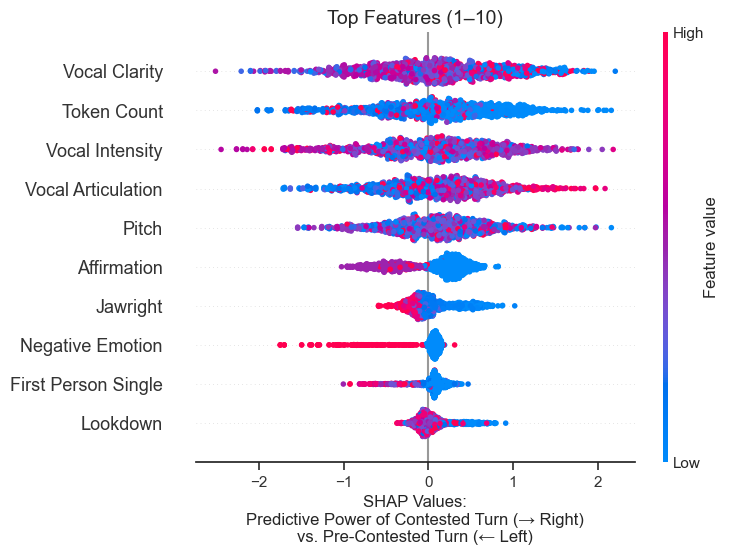

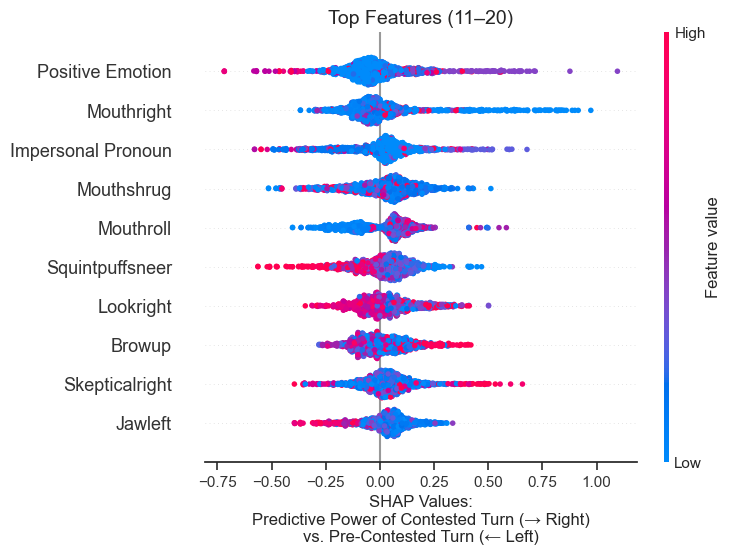

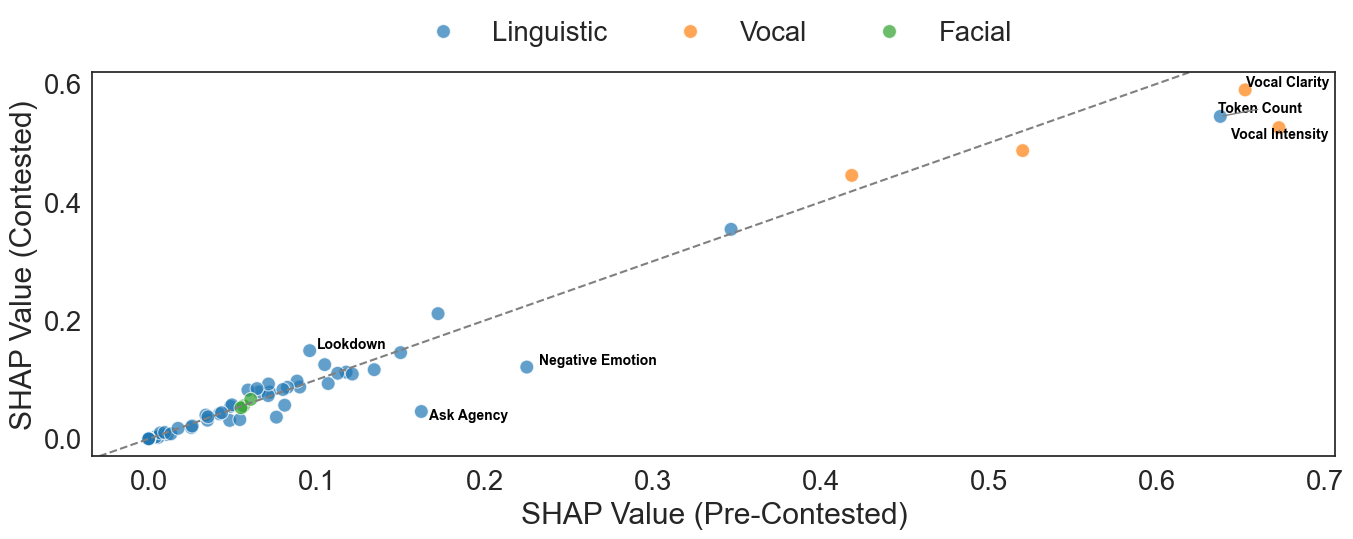

In [192]:
analyze_pre_contested_behaviors(df, negotiation_category="Shallow Exploration", n_prior_turns=2)


Step 3: Testing modality combinations

In [ ]:
def get_top1_behavior_combo(row, ling_feats, vocal_feats, facial_feats):
    top_ling = row[ling_feats].idxmax()
    top_vocal = row[vocal_feats].idxmax()
    top_facial = row[facial_feats].idxmax()
    return (top_ling, top_vocal, top_facial)


def extract_behavior_transitions(df, n_prior_turns=1):
    # Define and transform behavioral feature lists
    def format_feature(name):
        return name.replace('_', ' ').replace('YesNo', 'Yesno').replace('WH', 'Wh').replace('mouth', 'Mouth').replace('dimple', 'Dimple').replace('close', 'Close').replace('open', 'Open').replace('left', 'Left').replace('right', 'Right').replace('jaw', 'Jaw').title()

    ling_feats_raw = [
        'Acknowledgement', 'Affirmation', 'Agreement', 'Apology', 'Ask_Agency', 'By_The_Way', 'Can_You',
        'Conjunction_Start', 'Could_You', 'Disagreement', 'Filler_Pause', 'First_Person_Plural', 'First_Person_Single',
        'For_Me', 'For_You', 'Formal_Title', 'Give_Agency', 'Goodbye', 'Gratitude', 'Hedges', 'Hello',
        'Impersonal_Pronoun', 'Informal_Title', 'Let_Me_Know', 'Negation', 'Negative_Emotion', 'Please',
        'Positive_Emotion', 'Reasoning', 'Reassurance', 'Second_Person', 'Subjectivity', 'Swearing',
        'Truth_Intensifier', 'Bare_Command', 'YesNo_Questions', 'WH_Questions', 'Adverb_Limiter'
    ]
    vocal_feats_raw = ['Pitch', 'VocalIntensity', 'VocalArticulation', 'VocalClarity']
    facial_feats_raw = [
        'SquintPuffSneer', 'CompressedContortion', 'BrowUp', 'CheekPuffSneer', 'Blink', 'LookDown', 'LookRight',
        'LookLeft', 'LookUp', 'BlinkRight', 'EyesWide', 'OpenMouth', 'JawLeft', 'JawRight',
        'mouthClose_openJaw', 'mouthDimpleLeft', 'mouthDimpleRight', 'SkepticalRight', 'SneeringPucker',
        'mouthRight', 'mouthRoll', 'mouthShrug', 'Smile'
    ]

    ling_feats = [format_feature(f) for f in ling_feats_raw]
    vocal_feats = [format_feature(f) for f in vocal_feats_raw]
    facial_feats = [format_feature(f) for f in facial_feats_raw]
    behavioral_cols = ling_feats_raw + vocal_feats_raw + facial_feats_raw

    # Rename columns only for behavioral features
    rename_map = {col: format_feature(col) for col in behavioral_cols if col in df.columns}
    df.rename(columns=rename_map, inplace=True)

    all_combos = []

    for category in df['Negotiation_Category'].unique():
        df_cat = df[df['Negotiation_Category'] == category].copy()
        df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)

        for pid in df_cat['PairID'].unique():
            convo = df_cat[df_cat['PairID'] == pid].reset_index(drop=True)
            for i in range(n_prior_turns, len(convo)):
                current = convo.iloc[i]
                previous = convo.iloc[i - n_prior_turns]
                if current['Contested'] > 0 and previous['Contested'] == 0:
                    pre_combo = get_top1_behavior_combo(previous, ling_feats, vocal_feats, facial_feats)
                    cont_combo = get_top1_behavior_combo(current, ling_feats, vocal_feats, facial_feats)
                    all_combos.append({
                        'Negotiation_Category': category,
                        'PairID': pid,
                        'Turn_Pre': previous['Turn'],
                        'Turn_Contested': current['Turn'],
                        'Pre_Combo': pre_combo,
                        'Cont_Combo': cont_combo
                    })

    return pd.DataFrame(all_combos)


# Example usage:
# transitions_df = extract_behavior_transitions(df)
# transitions_df.groupby(['Negotiation_Category', 'Pre_Combo', 'Cont_Combo']).size().reset_index(name='Count')


In [224]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')

In [227]:
transitions_df = extract_behavior_transitions(df)
transitions_df.groupby(['Negotiation_Category', 'Pre_Combo', 'Cont_Combo']).size().reset_index(name='Count')

KeyError: "['Squint Puff Sneer', 'Compressed Contortion', 'Brow Up', 'Cheek Puff Sneer', 'Look Down', 'Look Right', 'Look Left', 'Look Up', 'Blink Right', 'Eyes Wide', 'Open Mouth', 'Jaw Left', 'Jaw Right', 'Mouthdimple Left', 'Mouthdimple Right', 'Skeptical Right', 'Sneering Pucker', 'Mouth Right', 'Mouth Roll', 'Mouth Shrug'] not in index"